In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import pandas_ta as ta


In [2]:
data=yf.download(tickers='^RUI', start='2012-03-11',end='2022-07-10')
data.head(10)

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2012-03-12,759.429993,760.619995,756.840027,759.130005,759.130005,0
2012-03-13,761.450012,773.030029,761.450012,772.979980,772.979980,0
2012-03-14,773.190002,774.679993,769.280029,771.630005,771.630005,0
2012-03-15,772.380005,776.469971,770.739990,776.419983,776.419983,0
2012-03-16,776.559998,778.099976,775.640015,777.130005,777.130005,0
2012-03-19,777.119995,782.549988,776.070007,780.090027,780.090027,0
2012-03-20,778.030029,778.299988,773.119995,777.369995,777.369995,0
2012-03-21,777.559998,778.650024,774.760010,776.150024,776.150024,0
2012-03-22,773.640015,773.640015,768.000000,770.270020,770.270020,0


In [3]:
#Adding indicators

data['RSI']=ta.rsi(data.Close, length=15)
data['EMAF']=ta.ema(data.Close, length=20) 
data['EMAM']=ta.ema (data. Close, length=100)
data['EMAS']=ta.ema (data.Close, length=150)

data['Target'] = data['Adj Close' ]-data.Open

data['Target'] = data['Target'].shift(-1)

data['TargetClass'] = [1 if data.Target[i]>0 else 0 for i in range(len(data))]

data['TargetNextClose'] = data['Adj Close'].shift(-1)

data.dropna(inplace=True)

data.reset_index(inplace = True)

data.drop(['Volume', 'Close', 'Date'], axis=1, inplace=True)

In [4]:
data_set = data.iloc[:, 0:11]#. values 
pd.set_option('display.max_columns', None)

data_set.head(5)

#print(data_set.shape)

#print(data.shape)

#print(type (data_set))

,Open,High,Low,Adj Close,RSI,EMAF,EMAM,EMAS,Target,TargetClass,TargetNextClose
0,791.440002,795.679993,789.760010,789.760010,46.877256,795.406526,775.179523,762.677734,-2.690002,0,787.179993
1,789.869995,792.669983,785.640015,787.179993,44.575540,794.623046,775.417156,763.002267,6.260010,1,793.440002
2,787.179993,794.020020,786.260010,793.440002,50.849388,794.510376,775.774044,763.405416,7.019958,1,801.599976
3,794.580017,801.859985,794.580017,801.599976,57.558969,795.185576,776.285448,763.911304,4.369995,1,805.039978
4,800.669983,805.770020,800.669983,805.039978,60.023875,796.124090,776.854845,764.456055,-0.809998,0,803.330017


In [5]:
from sklearn.preprocessing import MinMaxScaler

sc= MinMaxScaler(feature_range=(0,1))

data_set_scaled =sc.fit_transform(data_set)
print(data_set_scaled)



[[0.02295817 0.02294337 0.02477161 ... 0.61254467 0.         0.02075971]
 [0.02213767 0.02137597 0.02261574 ... 0.64462357 1.         0.02403152]
 [0.02073185 0.02207898 0.02294016 ... 0.6473474  1.         0.02829634]
 ...
 [0.70292872 0.70530315 0.68624737 ... 0.63741923 1.         0.71234811]
 [0.71004135 0.71485848 0.70603747 ... 0.72379951 1.         0.73006085]
 [0.7151577  0.72731964 0.71872676 ... 0.62397837 1.         0.72869667]]


In [6]:
# multiple feature from data provided to the model

X = []

#print(data_set_scaled[0].size)

#data_set_scaled-data_set.values

backcandles = 10

print(data_set_scaled.shape[0])

for j in range (8): #data_set_scaled[0].size): #2 columns are target not X
    X.append([])
    for i in range(backcandles, data_set_scaled.shape[0]): #backcandles+2 
        X[j].append(data_set_scaled[i-backcandles:i, j])

#move axis from 0 to position 2

X=np.moveaxis(X, [0], [2])

#Erase first elements of y because of backcandles to match X Length

#del (yi[0:backcandles])

#X, yi = np.array (X), np.array(yi)

# Choose -1 for last column, classification else -2...

X, yi= np.array(X), np.array(data_set_scaled[backcandles:, -1])

y=np.reshape(yi, (len(yi),1))

#y=sc.fit_transform(yi)

#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
#print(X)
print(X.shape)
#print(y)
print(y.shape)

2448
(2418, 30, 8)
(2418, 1)


In [7]:
# split data into train test sets 
splitlimit= int(len(X)*0.8)
print(splitlimit)
X_train, X_test = X[:splitlimit], X[splitlimit:]
y_train, y_test = y[:splitlimit], y[splitlimit:]

print (X_train.shape)

print(X_test.shape)

print (y_train.shape)

print(y_test.shape)

print(y_train)

1934
(1934, 30, 8)
(484, 30, 8)
(1934, 1)
(484, 1)
[[0.01673005]
 [0.01859073]
 [0.01876841]
 ...
 [0.56623563]
 [0.569612  ]
 [0.57616078]]


In [8]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Dense
from keras.layers import TimeDistributed

import tensorflow as tf
import keras
from keras import optimizers
from keras.callbacks import History
from keras.models import Model
from keras.layers import Dense, Dropout, LSTM, Input, Activation, concatenate
import numpy as np
#tf.random.set_seed(20)
np.random.seed(10)

lstm_input = Input(shape=(backcandles, 8), name='lstm_input')
inputs = LSTM(150, name='first_layer')(lstm_input)
inputs = Dense(1, name='dense_layer')(inputs)
output = Activation('linear', name='output')(inputs)
model = Model(inputs=lstm_input, outputs=output)
adam = optimizers.Adam()
model.compile(optimizer=adam, loss='mse')
model.fit(x=X_train, y=y_train, batch_size=15, epochs=30, shuffle=True, validation_split = 0.1)

Epoch 1/30
116/116 [==============================] - 6s 35ms/step - loss: 0.0011 - val_loss: 0.0013
Epoch 2/30
116/116 [==============================] - 4s 31ms/step - loss: 9.6660e-05 - val_loss: 0.0011
Epoch 3/30
116/116 [==============================] - 3s 27ms/step - loss: 9.1368e-05 - val_loss: 0.0011
Epoch 4/30
116/116 [==============================] - 4s 31ms/step - loss: 8.8575e-05 - val_loss: 9.8431e-04
Epoch 5/30
116/116 [==============================] - 4s 30ms/step - loss: 8.2192e-05 - val_loss: 0.0011
Epoch 6/30
116/116 [==============================] - 4s 30ms/step - loss: 8.5382e-05 - val_loss: 9.6957e-04
Epoch 7/30
116/116 [==============================] - 4s 30ms/step - loss: 9.5811e-05 - val_loss: 9.2531e-04
Epoch 8/30
116/116 [==============================] - 4s 31ms/step - loss: 8.6184e-05 - val_loss: 0.0011
Epoch 9/30
116/116 [==============================] - 3s 30ms/step - loss: 8.2624e-05 - val_loss: 8.8852e-04
Epoch 10/30
116/116 [======================

In [9]:
y_pred = model.predict(X_test)
#y_pred=np.where(y_pred > 0.43, 1,0)
for i in range(10):
    print(y_pred[i], y_test[i])

16/16 [==============================] - 1s 21ms/step
[0.5570611] [0.58137683]
[0.56241673] [0.58120438]
[0.56701183] [0.58292916]
[0.5686107] [0.57508415]
[0.57081556] [0.58856329]
[0.5662104] [0.58750759]
[0.5738842] [0.5871156]
[0.5761259] [0.59118701]
[0.5768079] [0.59328809]
[0.5801245] [0.58867832]


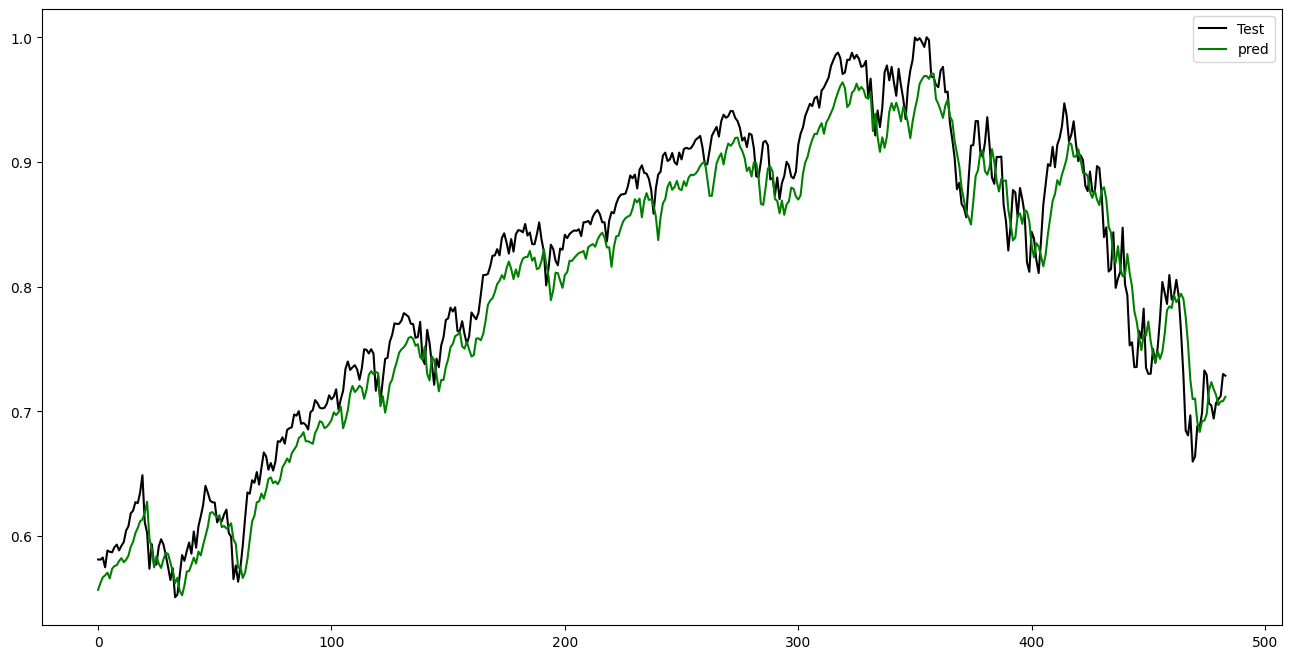

In [14]:
plt.figure(figsize=(16,8))
plt.plot(y_test, color = 'black', label = 'Test')
plt.plot(y_pred, color = 'green', label = 'pred')
plt.legend()
plt.show()